# Neural Style Transfer
This tutorial uses deep learning to compose one image in the style of another image (ever wish you could paint like Picasso or Van Gogh?). This is known as neural style transfer and the technique is outlined in A Neural Algorithm of Artistic Style ([Gatys et al](https://arxiv.org/abs/1508.06576).)



## Defination

1. Neural style transfer is an optimization technique used to take two images—a content image and a style reference image (such as an artwork by a famous painter)—and blend them together so the output image looks like the content image, but “painted” in the style of the style reference image.

    This is implemented by optimizing the output image to match the content statistics of the content image and the style statistics of the style reference image. These statistics are extracted from the images using a convolutional network.
    
2. During the past few years we’ve seen a slew of apps like prisma and other similar apps popping up which style your photos in a way wherein they look like paintings. Offering you a variety of beautiful styles some of which are paintings by famous artists like Starry Night by Van Gogh. Trying to explain this concept just with words might be difficult.


3. As you can see , there are two input images namely content image and style image that are used to a generate a new image called stylized image. A few things to notice about this image is that it has the same content as the content image and has a style similar to that of the style image. It looks good and we are pretty sure it’s not achieved by overlapping these two images so how do we get here what is the math behind this idea? To answer these question we need to take a step back and focus on what does a convolution neural network actually learn? What are these Convolution layers truly encoding in form of feature maps or kernels that lets them do this or stating this in another way What representations do CNNs learn when we input an image, let’s try to understand that first. Convolutional Neural Networks were originally created for classification of images and have lately been used in a variety of other tasks like Image Segmentation, Neural Style and other computer vision and Natural Language Processing tasks as well. CNNs are one of the most interpretable models in Deep Learning because of our ability to visual their representations and understand what they might be learning.
![Example 1](https://miro.medium.com/max/875/0*F3xvwBKFhaQ3Mh_k)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import os
os.listdir('../input/neural-style-transfer')
plt.rcParams["figure.figsize"] = (20,10)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Intro to Transfer Learning

For intro to transfer learning check out:
* [Blood cell Classification with TF](https://www.kaggle.com/tathagatbanerjee/blood-cell-detection-100-acc-transfer-learning)
* [Hand Recognition using TF](https://www.kaggle.com/tathagatbanerjee/hand-recognition-cnn-model-plot-feature-plot)

If your good to go with python and Transfer Learning lets move forward: 
Although the use of different transfer learing algorithms, techniques and optimization is vividly used in the domain but in 2016 gatys first thought about what if we freeze the initialised weights and optimise the image. The idea is to tender a loss built over content and style images and optimise the image to minimise the loss. 
Chillax if you dont understand and find it latin, lets go slow and see what Transfer learning especially vgg model has for us

## VGG
![VGG16](https://miro.medium.com/max/875/0*sgoGO_rnawcajCbH)
1. Now let’s consider the 10th convolution layer of vgg16 which uses a 3x3 kernel with 512 feature maps to train and finally generates a output of 28X28x512 image representation, just for sake of simplicity let’s assume that there are certain units in this 10th layer which gets activated by an image containing circles like wheel of a car or there might be some which get activated by an image having some pattern similar to three intersecting lines etc.
2. It’s safe to assume that CNN does not learn to encode what image is but it actually learns to encode what image represents or what contents are visible in the image and due to inherent nonlinear nature of neural networks has we go from shallow layers to deeper layers the hidden units become capable to detect more and more complex feature from a given image.

In [9]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        # The first number x in convx_y gets added by 1 after it has gone
        # through a maxpool, and the second y if we have several conv layers
        # in between a max pool. These strings (0, 5, 10, ..) then correspond
        # to conv1_1, conv2_1, conv3_1, conv4_1, conv5_1 mentioned in NST paper
        self.chosen_features = ["0", "5", "10", "19", "28"]

        # We don't need to run anything further than conv5_1 (the 28th module in vgg)
        # Since remember, we dont actually care about the output of VGG: the only thing
        # that is modified is the generated image (i.e, the input).
        self.model = models.vgg19(pretrained=True).features[:29]

    def forward(self, x):
        # Store relevant features
        features = []

        # Go through each layer in model, if the layer is in the chosen_features,
        # store it in features. At the end we'll just return all the activations
        # for the specific layers we have in chosen_features
        for layer_num, layer in enumerate(self.model):
            x = layer(x)

            if str(layer_num) in self.chosen_features:
                features.append(x)

        return features
model = VGG().to(device).eval()
model

VGG(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding

# Lets Load the Image first

In [10]:
imsize = 500
loader = transforms.Compose(
    [
        transforms.Resize((imsize, imsize)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x  )
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
def load_image(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    print(image.shape)
    
    return image.to(device)

# Hyperparameter

In [11]:
content_name = 'tubingen'
style_name='candy'
original_img = load_image("../input/neural-style-transfer/content-images/"+content_name+".png")
style_img = load_image("../input/neural-style-transfer/style-images/"+style_name+".jpg")
generated = original_img.clone().requires_grad_(True)

# Hyperparameters
total_steps = 12000
learning_rate = 0.0001
alpha = 1
beta = 0.01
optimizer = optim.Adam([generated], lr=learning_rate)



torch.Size([1, 3, 500, 500])
torch.Size([1, 3, 500, 500])


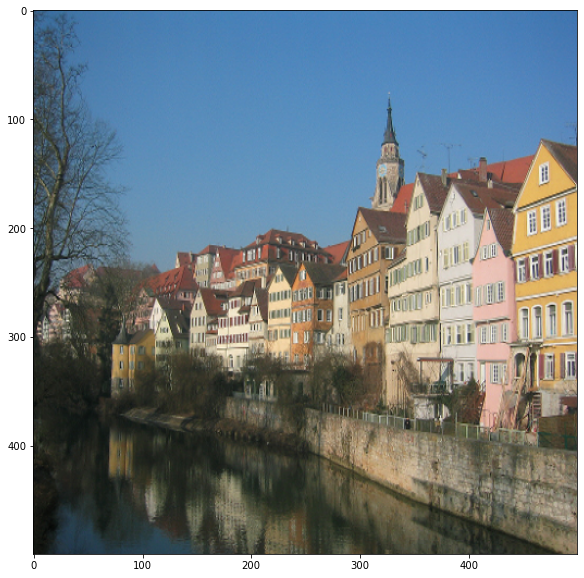

In [12]:
npy = original_img[0].cpu().permute(1,2,0).detach().numpy()
plt.imshow(npy)

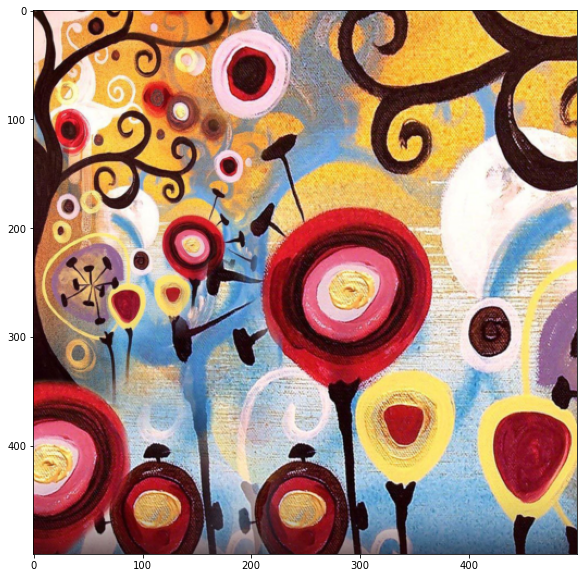

In [13]:
plt.imshow(style_img[0].cpu().permute(1,2,0).detach().numpy())

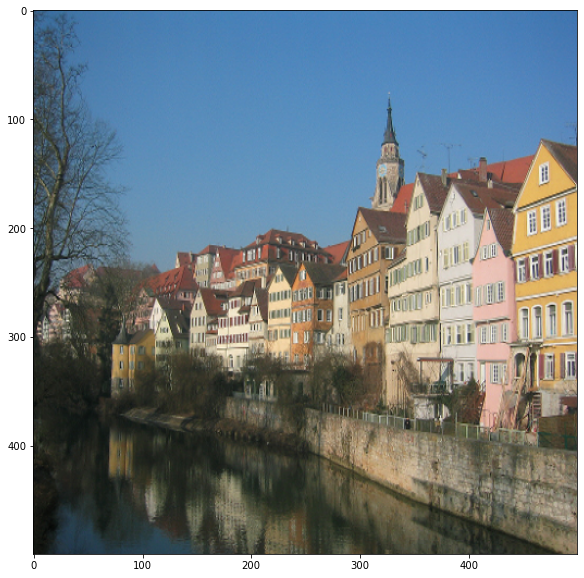

In [14]:
npy = generated[0].cpu().permute(1,2,0).detach().numpy()
plt.imshow(npy)

In [15]:

video_name = content_name+'_'+style_name+'.avi'

video = cv2.VideoWriter(video_name, 0, 1, (imsize,imsize))


# Working

## LOSS
![LOSS](https://miro.medium.com/max/875/1*INwW0Apz4wUpDS9jetJ7xQ.jpeg)
What are the inputs to this loss function displayed above? We have no idea how the final output might look. So the naive approach of supervised learning might not work. The answer lies in the image below.
![ARCH](https://miro.medium.com/max/875/0*gq-qNqxE3b37o3dO)

## Content Loss
![CL](https://miro.medium.com/max/875/1*34xPuexhGCHT7xZ17wVvDQ.jpeg)

## Style Loss

Now let’s look at the style loss, while calculating the style loss we will consider feature representation of many convolution layers from shallow to deeper layers of the model. Unlike content loss we can’t just find the difference in activation units, What we need is a way to find the correlation between these activations across different channels of the same layer and to do this we need something called as the Gram Matrix.

### Gram Matrix : It calculates a global statistics of feature maps, kinda correlation but globally on the feature map

![SL](https://miro.medium.com/max/875/1*IoozR3xGzaSqtEqGEKcWMQ.jpeg)


In [16]:

start = datetime.datetime.now()
for step in range(total_steps):
    # Obtain the convolution features in specifically chosen layers
    generated_features = model(generated)
    original_img_features = model(original_img)
    style_features = model(style_img)

    # Loss is 0 initially
    style_loss = original_loss = 0

    # iterate through all the features for the chosen layers
    for gen_feature, orig_feature, style_feature in zip(
        generated_features, original_img_features, style_features
    ):

        # batch_size will just be 1
        batch_size, channel, height, width = gen_feature.shape
        original_loss += torch.mean((gen_feature - orig_feature) ** 2)
        # Compute Gram Matrix of generated
        G = gen_feature.view(channel, height * width).mm(
            gen_feature.view(channel, height * width).t()
        )
        # Compute Gram Matrix of Style
        A = style_feature.view(channel, height * width).mm(
            style_feature.view(channel, height * width).t()
        )
        style_loss += torch.mean((G - A) ** 2)

    total_loss = alpha * original_loss + beta * style_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    
    if step % 200 == 0 or step < 5:
        stop = datetime.datetime.now()
        elapsed =  (stop-start).total_seconds()
        print('At step : '+str(step)+' Loss:'+str(total_loss)+' in time : '+str(elapsed))
        img = generated[0].cpu().permute(1,2,0).detach().numpy()
        video.write((img*255).astype(np.uint8))
        start = datetime.datetime.now()

At step : 0 Loss:tensor(4912146.5000, device='cuda:0', grad_fn=<AddBackward0>) in time : 0.768282
At step : 1 Loss:tensor(4897859.5000, device='cuda:0', grad_fn=<AddBackward0>) in time : 0.014486
At step : 2 Loss:tensor(4883527., device='cuda:0', grad_fn=<AddBackward0>) in time : 0.01664
At step : 3 Loss:tensor(4869102., device='cuda:0', grad_fn=<AddBackward0>) in time : 0.013878
At step : 4 Loss:tensor(4854574.5000, device='cuda:0', grad_fn=<AddBackward0>) in time : 0.014267
At step : 200 Loss:tensor(1974826., device='cuda:0', grad_fn=<AddBackward0>) in time : 33.723329
At step : 400 Loss:tensor(1313910.6250, device='cuda:0', grad_fn=<AddBackward0>) in time : 34.411144
At step : 600 Loss:tensor(954753.5000, device='cuda:0', grad_fn=<AddBackward0>) in time : 34.409636
At step : 800 Loss:tensor(740547., device='cuda:0', grad_fn=<AddBackward0>) in time : 34.412766
At step : 1000 Loss:tensor(606628.3125, device='cuda:0', grad_fn=<AddBackward0>) in time : 34.412425
At step : 1200 Loss:tens

In [17]:
video.release()
def convert_avi_to_mp4(avi_file_path, output_name):
    os.popen("ffmpeg -i '{input}' -ac 2 -b:v 2000k -c:a aac -c:v libx264 -b:a 160k -vprofile high -bf 0 -strict experimental -f mp4 '{output}.mp4'".format(input = avi_file_path, output = output_name))
    return True
convert_avi_to_mp4('./taj_mahal_mosaic.avi','taj_mahal_mosaic')

True

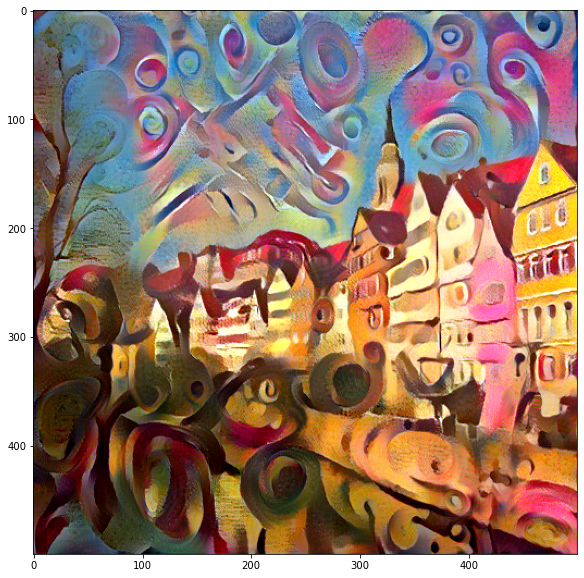

In [18]:
npy = generated[0].cpu().permute(1,2,0).detach().numpy()
plt.imshow(npy)

In case you understood something or get excited or even just thought to read till here, a big thank you. Please upvote and comment for any clarification. I know my underatnding isnt complete and in future will try to improve. I belive the lack of readable jupyter tutorial was present in the field due to which i made this. I hope you like my work. If you would like to see more notebooks I have build through please check [this](https://www.kaggle.com/tathagatbanerjee/code) 


Cheers

Tathagat

# References 
[1] https://www.tensorflow.org/tutorials/generative/style_transfer


[2] https://towardsdatascience.com/neural-style-transfer-tutorial-part-1-f5cd3315fa7f


[3] https://towardsdatascience.com/how-to-get-beautiful-results-with-neural-style-transfer-75d0c05d6489


[4] https://medium.com/tensorflow/neural-style-transfer-creating-art-with-deep-learning-using-tf-keras-and-eager-execution-7d541ac31398
